In [1]:
import pandas as pd
import yaml
import os
#import cv2                  #conda install conda-forge::opencv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
%run parallel_functions.py
from parallel_functions import read_image_and_bbox, read_and_process_file
from joblib import Parallel, delayed
import lightning as L
import torch
import imageio.v2 as imageio


with open('data.yaml', 'r') as f:
    train_data = yaml.safe_load(f)
    number_classes=train_data['nc']
    classes=train_data['names']
    
test_path="./test"

num_jobs=16

print(test_path)

def get_files(path, endswith):
    files = []
    for root, dirs, file in os.walk(path):
        for f in file:
            if f.endswith(endswith):
                files.append(f)
    return files

test_images=get_files(test_path+"/images", ".jpg")
test_labels=get_files(test_path+"/labels", ".txt")



def read_and_process_file(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ['class', 'x', 'y', 'w', 'h']
    df['image'] = os.path.basename(file_path).replace('.txt', '.jpg')
    df['class'] = df['class'].astype(int)+1
    return df

df_collection=Parallel(n_jobs=num_jobs)(delayed(read_and_process_file)(test_path+"/labels/"+file) for file in test_labels)
df=pd.concat(df_collection, ignore_index=True)
test_path=test_path+"/images"

class_dict={}
for i in range(number_classes):
    class_dict[i+1]=classes[i]
class_dict[0]='None'
number_classes=len(class_dict)


test_chunks = [group for _, group in df.groupby('image')]
def read_image_and_bbox(chunck, path):
    image = imageio.imread(path+"/"+chunck.iloc[0]['image'])
    image = Image.fromarray(image)
    return {"image": image, "chunck": chunck}

test_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, test_path) for chunck in test_chunks)

./test


<Axes: >

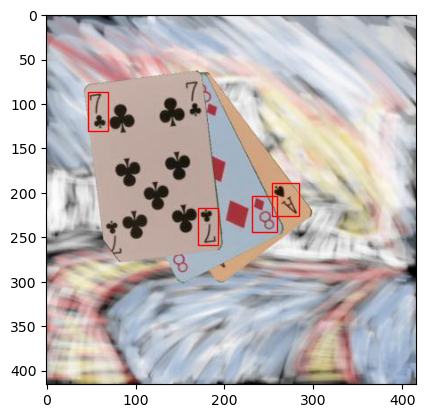

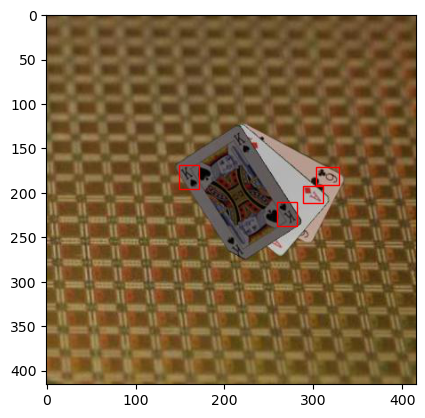

In [2]:
def show_boxes(image_data, show_class=False, ax=None):
    image=image_data['image']
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.imshow(image)
    width, height = image.size
    bboxes=image_data["chunck"]
    
    for i in range(len(bboxes)):
        bbox=bboxes.iloc[i]
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')	
        if show_class:
            ax.text(x-w/2, y-h/2, class_dict[bbox['class']], fontsize=12, color='white', backgroundcolor='red')
        ax.add_patch(rect)
    return ax

show_boxes(test_data[0])
show_boxes(test_data[1230])

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.df = df
        self.data = data
        self.size=len(data)
        self.transform = transform
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        if self.transform:
            image = self.transform(image)
        return image
    
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])
dataset = Dataset(test_data, transform)

print(dataset[0].shape) 

torch.Size([3, 416, 416])


In [13]:
import torchvision
from torchvision.models import ResNet50_Weights
import torch
import gc
import sys

class Model(L.LightningModule):
    def __init__(self, loss_fun=None, hidden_size=None, dropout=0.4, params=None, train_dataset=None, val_dataset=None):
        super().__init__()
        self.backbone=torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone_output_size=1000
        number_boxes=4
        self.neurons_per_box=4      
        output_neurons=number_boxes*self.neurons_per_box
        self.loss_fun=loss_fun
        self.params=params
        self.train_dataset=train_dataset
        self.val_dataset=val_dataset
        
        self.head=torch.nn.Sequential(
            torch.nn.Linear(self.backbone_output_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, output_neurons),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x=self.backbone(x)
        x=x.view(-1, self.backbone_output_size)
        x=self.head(x)
        return x
 
    def validation_step(self, batch, batch_idx):
        image, target, _ = batch
        output = self(image)
        loss = self.loss_fun(output, target['boxes'])
        self.custom_log("val_loss", loss.detach())
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
        
from lightning.pytorch.callbacks import ModelCheckpoint


# loader model from checkpoint
model = Model.load_from_checkpoint(
    checkpoint_path='/home/bernd/_developer/cards_object_detection/cards_bbox-epoch=36-val_loss=44.92.ckpt', hidden_size=1000
)

In [37]:
from lightning import Trainer

dataloader=torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
trainer = Trainer()
predictions = trainer.predict(model, dataloader)
print(predictions[0])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 125/125 [00:04<00:00, 29.66it/s]
tensor([[0.6409, 0.4842, 0.0886, 0.1012, 0.5748, 0.5253, 0.0749, 0.1180, 0.4534,
         0.5509, 0.0658, 0.1297, 0.1181, 0.2739, 0.0646, 0.1327],
        [0.5578, 0.1665, 0.0596, 0.1051, 0.6482, 0.1927, 0.0648, 0.1029, 0.7381,
         0.2336, 0.0720, 0.0911, 0.7853, 0.6540, 0.0781, 0.0930],
        [0.8523, 0.4582, 0.0845, 0.1094, 0.3724, 0.1923, 0.0946, 0.1313, 0.4739,
         0.5943, 0.0874, 0.1291, 0.0044, 0.0043, 0.0058, 0.0075],
        [0.4410, 0.2648, 0.0645, 0.0994, 0.4857, 0.5049, 0.0669, 0.1002, 0.3575,
         0.7664, 0.0770, 0.0799, 0.4579, 0.4613, 0.0812, 0.0849],
        [0.3234, 0.6236, 0.0827, 0.0706, 0.5800, 0.6118, 0.0804, 0.0758, 0.1974,
         0.4105, 0.0598, 0.0660, 0.3709, 0.4046, 0.0694, 0.0697],
        [0.6296, 0.2198, 0.0924, 0.0949, 0.4121, 0.3822, 0.0952, 0.0838, 0.8332,
         0.5877, 0.1083, 0.0907, 0.6001, 0.7120, 0.1111, 0.0968],
        [0.1815, 0.4902, 0.1318, 0.1295, 0.

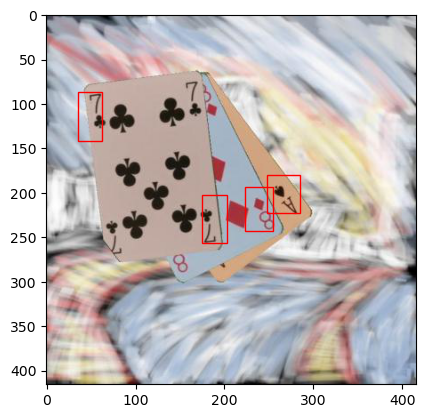

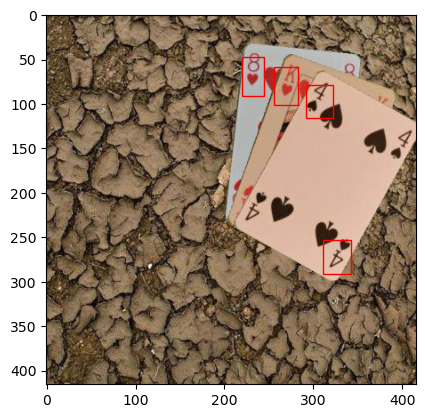

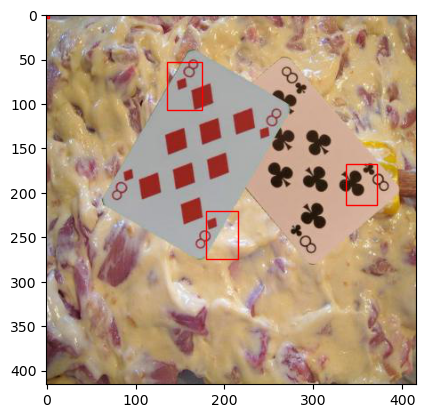

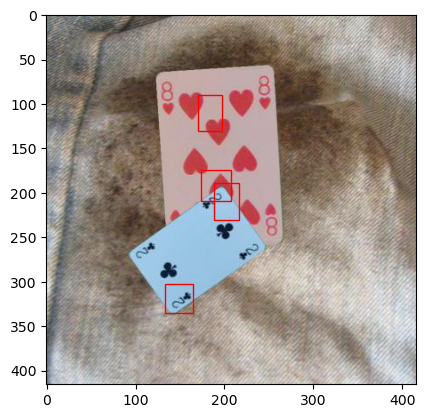

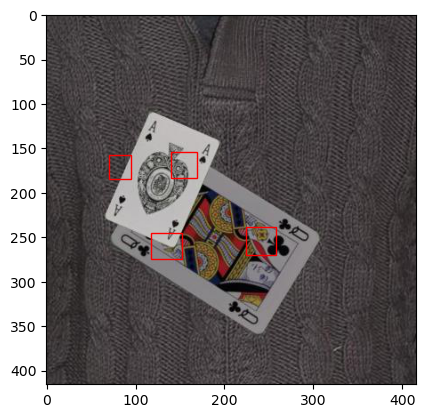

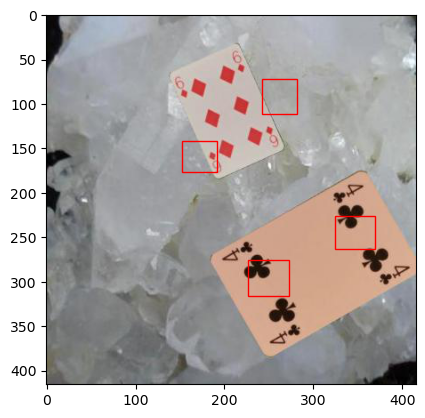

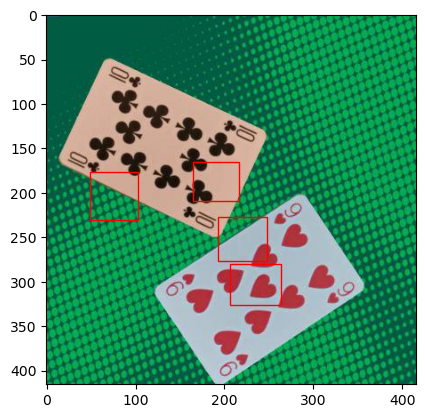

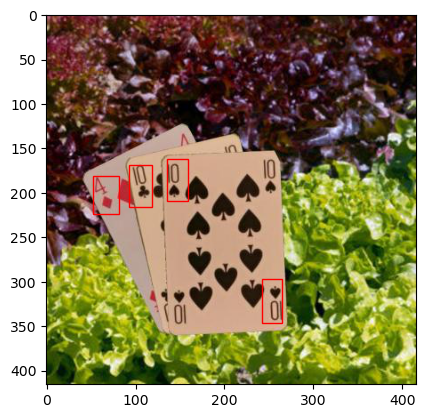

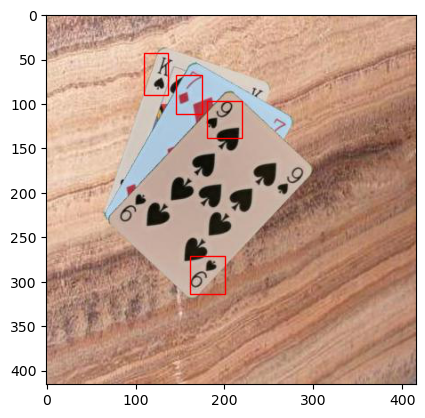

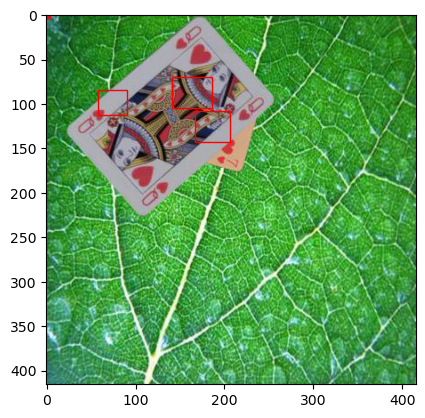

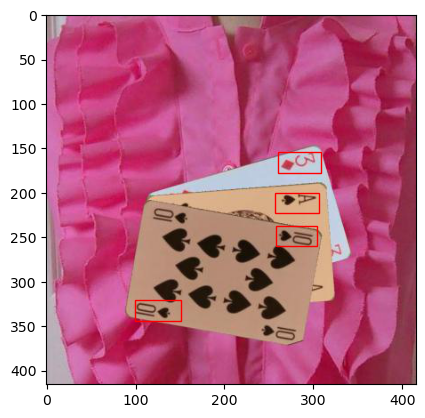

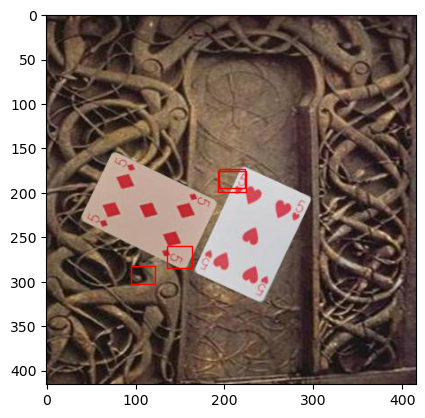

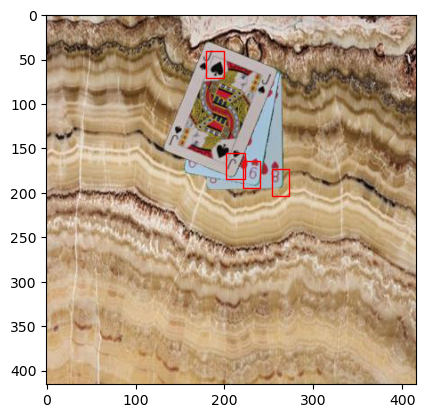

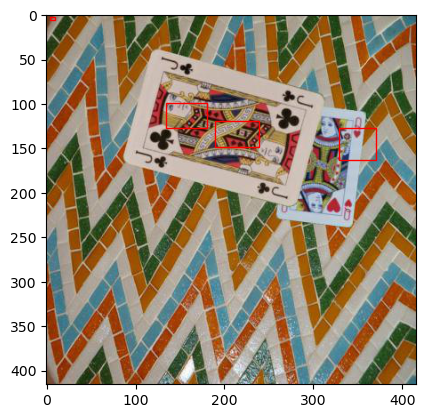

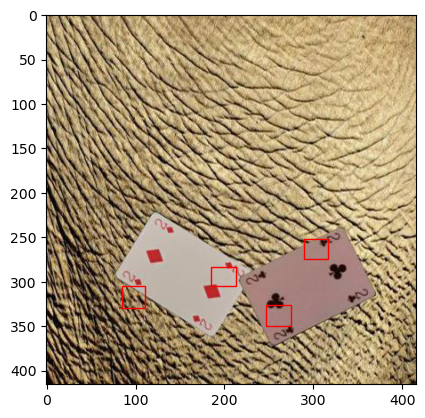

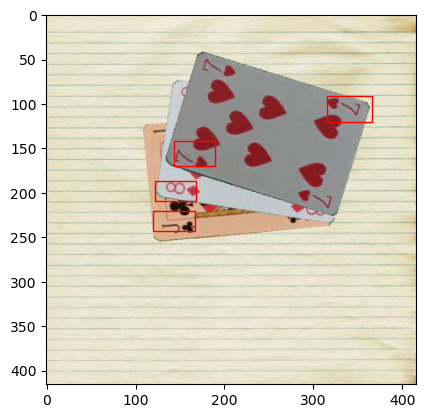

In [38]:
for xb in dataloader:
    for idx, image in enumerate(xb):
        bboxes=predictions[0][idx].detach().numpy()
        image=dataset[idx]
        image=image.permute(1, 2, 0).numpy()
        image = Image.fromarray((image * 255).astype(np.uint8))
        bboxes=bboxes.reshape(-1, 4)
        show_boxes({"image": image, "chunck": pd.DataFrame(bboxes, columns=['x', 'y', 'w', 'h'])})
    break
    